# 2d contacts

Author: Jukka Aho

Abstract: 2d tie contact.

## Model 1: three body tie contact


![model](http://s4.postimg.org/u9yqeryul/Screenshot_from_2015_11_24_02_00_00.png)

Each element is modelled as own "body" and they are connected using tie contacts. Segments 5-6 and 9-10 and 6-7 are slave surfaces, so node 6 or 9 is on at least two tie contacts as slave node. Moreover this model has dirichlet boundary $y=0$ at bottom of body 1 and $x=0$ on left. To get the accurate solution one needs to minimize 
\begin{equation}
\frac{15}{2}u_1^4 + 60 u_1^3 + \frac{15}{4}u_1^2 u_2^2 + 15 u_1^2 u_2 + 120 u_1^2 + 15 u_1 u_2^2 + 60 u_1 u_2 + \frac{15}{2}u_2^4 + 60 u_2^3 + 120 u_2^2 + 50 u_2,
\end{equation}
which gives approximate $u_1 = 0.0634862$ and $u_2 = -0.277183$ for the displacement of upper right corner.
[Wolfram](http://www.wolframalpha.com/input/?i=local+minimum+15*x^4%2F2+%2B+60*x^3+%2B+15*x^2*y^2%2F4+%2B+15*x^2*y+%2B+120*x^2+%2B+15*x*y^2+%2B+60*x*y+%2B+15*y^4%2F2+%2B+60*y^3+%2B+120*y^2+%2B+50*y).

In [1]:
using JuliaFEM.Core: Element, Seg2, Quad4, PlaneStressElasticityProblem,
                     DirichletProblem, MortarProblem, DirectSolver

In [10]:
nodes = Dict{Int64, Vector{Float64}}(
    1 => [0.0, 0.0], 2 => [2.0, 0.0],
    3 => [2.0, 1.0], 4 => [0.0, 1.0],
    5 => [0.0, 1.0], 6 => [1.0, 1.0],
    7 => [1.0, 2.0], 8 => [0.0, 2.0],
    9 => [1.0, 1.0], 10 => [2.0, 1.0],
    11 => [2.0, 2.0], 12 => [1.0, 2.0]);

In [11]:
connectivity = Dict{Int64, Vector{Int64}}(
    1 => [1, 2, 3, 4],
    2 => [5, 6, 7, 8],
    3 => [9, 10, 11, 12]);

In [13]:
elements = Element[]
for c in values(connectivity)
    element = Quad4(c)
    element["geometry"] = Vector{Float64}[nodes[i] for i in c]
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    push!(elements, element)
end
nelements = length(elements)
info("number of elements: $nelements")

INFO: number of elements: 3


Create three bodies, each containing one element.

In [14]:
body1 = PlaneStressElasticityProblem("body 1")
body2 = PlaneStressElasticityProblem("body 2")
body3 = PlaneStressElasticityProblem("body 3")
push!(body1, elements[1])
push!(body2, elements[2])
push!(body3, elements[3]);

Surface traction to the top of bodies 2 and 3:

In [15]:
t2 = Seg2([8, 7])
t2["geometry"] = Vector{Float64}[nodes[8], nodes[7]]
t2["displacement traction force"] = Vector{Float64}[[0.0, -100.0], [0.0, -100.0]]
t3 = Seg2([12, 11])
t3["geometry"] = Vector{Float64}[nodes[12], nodes[11]]
t3["displacement traction force"] = Vector{Float64}[[0.0, -100.0], [0.0, -100.0]]
push!(body2, t2)
push!(body3, t3);

Boundary conditions: $x=0$ for left boundary.

In [16]:
dx1 = Seg2([1, 4])
dx1["geometry"] = Vector[nodes[1], nodes[4]]
dx1["displacement 1"] = 0.0
dx2 = Seg2([5, 8])
dx2["geometry"] = Vector[nodes[5], nodes[8]]
dx2["displacement 1"] = 0.0
bc1 = DirichletProblem("displacement", 2)
push!(bc1, dx1)
push!(bc1, dx2);

$y=0$ for bottom of model

In [17]:
dy1 = Seg2([1, 2])
dy1["geometry"] = Vector[nodes[1], nodes[2]]
dy1["displacement 2"] = 0.0
bc2 = DirichletProblem("displacement", 2)
push!(bc2, dy1);

Mortar boundary conditions: tie contact between body 1 and body 2

In [19]:
#rotation_matrix(phi) = [cos(phi) -sin(phi); sin(phi) cos(phi)]
using JuliaFEM.Core: calculate_normal_tangential_coordinates!

master1 = Seg2([4, 3])
master1["geometry"] = Vector[nodes[4], nodes[3]]
slave1 = Seg2([5, 6])
slave1["geometry"] = Vector[nodes[5], nodes[6]]
slave1["master elements"] = Element[master1]
calculate_normal_tangential_coordinates!(slave1, 0.0)

#slave1["nodal ntsys"] = Matrix[rotation_matrix(-pi/2), rotation_matrix(-pi/2)]
contact1 = MortarProblem("displacement", 2)
push!(contact1, slave1);

Tie contact between body 1 and body 3

In [20]:
slave2 = Seg2([9, 10])
slave2["geometry"] = Vector[nodes[9], nodes[10]]
#slave2["nodal ntsys"] = Matrix[rotation_matrix(-pi/2), rotation_matrix(-pi/2)]
slave2["master elements"] = Element[master1]
calculate_normal_tangential_coordinates!(slave2, 0.0)
contact2 = MortarProblem("displacement", 2)
push!(contact2, slave2);

Tie contact between body 2 and body 3

In [21]:
master2 = Seg2([6, 7])
master2["geometry"] = Vector[nodes[6], nodes[7]]
slave3 = Seg2([9, 12])
slave3["geometry"] = Vector[nodes[9], nodes[12]]
#slave3["nodal ntsys"] = Matrix[rotation_matrix(0.0), rotation_matrix(0.0)]
calculate_normal_tangential_coordinates!(slave3, 0.0)
slave3["master elements"] = Element[master2]
contact3 = MortarProblem("displacement", 2)
push!(contact3, slave3);

All defined. Solve it.

In [22]:
solver = DirectSolver()
push!(solver, body1)
push!(solver, body2)
push!(solver, body3)
push!(solver, bc1)
push!(solver, bc2)
push!(solver, contact1)
push!(solver, contact2)
push!(solver, contact3);

In [23]:
iterations, converged = call(solver, 0.0)

INFO: Starting solver DirectSolver
INFO: # of field problems: 3
INFO: # of boundary problems: 5
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: body 1
INFO: Assembling body 2: body 2
INFO: Assembling body 3: body 3
INFO: dim = 24
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary
INFO: Assembling boundary 2: dirichlet boundary
INFO: Assembling boundary 3: mortar problem
INFO: Assembling boundary 4: mortar problem
INFO: Assembling boundary 5: mortar problem
INFO: Solving system
INFO: UMFPACK: solved in 0.3197059631347656 seconds. norm = 0.5357583756107197
INFO: timing info for iteration:
INFO: boundary assembly       : 0.3747282028198242
INFO: field assembly          : 2.646785020828247
INFO: dump matrices to disk   : 9.5367431640625e-7
INFO: solve problem           : 0.4615659713745117
INFO: update element data     : 0.02040410041809082
INFO: non-linear iteration    : 3.5035040378570557
INFO: Starting iteration 2

(5,true)

INFO: boundary assembly       : 0.035440921783447266
INFO: field assembly          : 0.0363919734954834
INFO: dump matrices to disk   : 0.0
INFO: solve problem           : 0.06740903854370117
INFO: update element data     : 0.0001380443572998047
INFO: non-linear iteration    : 0.13939404487609863
INFO: solver finished in 4.193101167678833 seconds.


In [24]:
using JuliaFEM.Test

@test converged

X = elements[2]("geometry", [1.0, 1.0], 0.0)
u = elements[2]("displacement", [1.0, 1.0], 0.0)
info("displacement at $X = $u")
@test isapprox(u, [0.0634862, -0.277183], atol=1.0e-5)

INFO: displacement at [2.0,2.0] = [0.06348623177789363,-0.2771830378556528]


Test Passed
  Expression: isapprox(u,[0.0634862,-0.277183],atol=1.0e-5)

## Model 2: splitted beam, tie contact

<img src="http://results.juliafem.org/splitted-2d-beam/2015-12-22-splitted-beam-mesh.png">

Put some load to the top, dx=dy=0 on left boundary.

In [1]:
using JuliaFEM.Preprocess: parse_aster_med_file
using JuliaFEM.Core: PlaneStressLinearElasticityProblem, DirichletProblem,
                     get_connectivity, Quad4, Tri3, Seg2, LinearSolver,
                     update!, get_elements

In [2]:
mesh = parse_aster_med_file(Pkg.dir("JuliaFEM")*"/geometry/2d_beam/BEAM.med")

INFO: Found 5 element sets: LOWER_TO_UPPER, RIGHT, UPPER_TO_LOWER, LEFT, LOAD


Dict{ASCIIString,Any} with 2 entries:
  "nodes"        => Dict(68=>[71.42857142857142,9.999999999999998],2=>[95.0,-4.…
  "connectivity" => Dict(11=>(:SE2,:OTHER,[11,12]),134=>(:TR3,:OTHER,[75,96,76]…

In [8]:
field_problem = PlaneStressLinearElasticityProblem()

# field problems
joo = Dict(:QU4 => Quad4, :TR3 => Tri3)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype in keys(joo) || continue
    element = joo[eltype](elcon)
    update!(element, "geometry", mesh["nodes"])
    element["youngs modulus"] = 900.0
    element["poissons ratio"] = 0.25
    push!(field_problem, element)
end

# neumann boundary condition -1 on y direction
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :SE2 || continue
    elset == :LOAD || continue
    element = Seg2(elcon)
    update!(element, "geometry", mesh["nodes"])
    element["displacement traction force 2"] = -1.0
    push!(field_problem, element)
end

# boundary conditions
boundary_problem = DirichletProblem("displacement", 2)

for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :SE2 || continue
    elset == :LEFT || continue
    element = Seg2(elcon)
    update!(element, "geometry", mesh["nodes"])
    element["displacement"] = 0.0
    push!(boundary_problem, element)
end

info("created $(length(get_elements(field_problem))) field elements.")
info("created $(length(get_elements(boundary_problem))) boundary elements.")

INFO: created 104 field elements.
INFO: created 4 boundary elements.


Contact definition: contact pair is `LOWER_TO_UPPER <--> UPPER_TO_LOWER`:

In [9]:
using JuliaFEM.Core: Element, MortarProblem, calculate_normal_tangential_coordinates!

mortar_surface = :UPPER_TO_LOWER
slave_surface = :LOWER_TO_UPPER

master_elements = JuliaFEM.Core.Element[]
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :SE2 || continue
    elset == mortar_surface || continue
    element = Seg2(elcon)
    update!(element, "geometry", mesh["nodes"])
    push!(master_elements, element)
end

contact_problem = MortarProblem("displacement", 2)
for (elid, (eltype, elset, elcon)) in mesh["connectivity"]
    eltype == :SE2 || continue
    elset == slave_surface || continue
    element = Seg2(elcon)
    update!(element, "geometry", mesh["nodes"])
    element["master elements"] = master_elements
    calculate_normal_tangential_coordinates!(element, 0.0)
    push!(contact_problem, element)
end

info("# of master elements: $(length(master_elements))")
info("# of slave elements: $(length(contact_problem.elements))")

INFO: # of master elements: 14
INFO: # of slave elements: 20


In [10]:
using JuliaFEM.Core: DirectSolver
solver = DirectSolver()
solver.name = "divided_beam"
solver.method = :UMFPACK
solver.nonlinear_problem = false
solver.max_iterations = 1
solver.dump_matrices = false
push!(solver, field_problem)
push!(solver, boundary_problem)
push!(solver, contact_problem)
call(solver, 0.0)

INFO: Starting solver divided_beam
INFO: # of field problems: 1
INFO: # of boundary problems: 2
INFO: Starting iteration 1
INFO: Assembling field problems...
INFO: Assembling body 1: plane stress linear elasticity
INFO: Assembly: 10.0 % done. 
INFO: Assembly: 20.0 % done. 
INFO: Assembly: 30.0 % done. 
INFO: Assembly: 40.0 % done. 
INFO: Assembly: 50.0 % done. 
INFO: Assembly: 60.0 % done. 
INFO: Assembly: 70.0 % done. 
INFO: Assembly: 80.0 % done. 
INFO: Assembly: 90.0 % done. 
INFO: Assembly: 100.0 % done. 
INFO: dim = 210
INFO: Assembling boundary problems...
INFO: Assembling boundary 1: dirichlet boundary
INFO: Assembling boundary 2: mortar problem
INFO: Solving system
INFO: UMFPACK: solved in 0.0015990734100341797 seconds. norm = 104.93886213441557


(1,true)

INFO: timing info for iteration:
INFO: boundary assembly       : 0.09911894798278809
INFO: field assembly          : 0.05243706703186035
INFO: dump matrices to disk   : 9.5367431640625e-7
INFO: solve problem           : 0.07156205177307129
INFO: update element data     : 0.0012559890747070312
INFO: non-linear iteration    : 0.2243940830230713
INFO: solver finished in 0.22567105293273926 seconds.


In [11]:
xdoc, xmodel = JuliaFEM.Postprocess.xdmf_new_model()
coll = JuliaFEM.Postprocess.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.Postprocess.xdmf_new_grid(coll; time=0.0)

Xg = Dict{Int64, Vector{Float64}}()
ug = Dict{Int64, Vector{Float64}}()
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    for (i, c) in enumerate(conn)
        Xg[c] = X[i]
        ug[c] = u[i]
    end
end
perm = sort(collect(keys(Xg)))
nodes = Vector{Float64}[Xg[i] for i in perm]
disp = Vector{Float64}[ug[i] for i in perm]
elements = []

for el in field_problem.elements
    isa(el, Element{Quad4}) || continue
    push!(elements, (:Quad4, get_connectivity(el)))
end
for el in field_problem.elements
    isa(el, Element{Tri3}) || continue
    push!(elements, (:Tri3, get_connectivity(el)))
end

#elements
JuliaFEM.Postprocess.xdmf_new_mesh!(grid, nodes, elements)
JuliaFEM.Postprocess.xdmf_new_nodal_field!(grid, "displacement", disp)
JuliaFEM.Postprocess.xdmf_save_model(xdoc, "/tmp/beam_2d.xmf");

INFO: XDFM: ndim = 210


In [13]:
using PyPlot

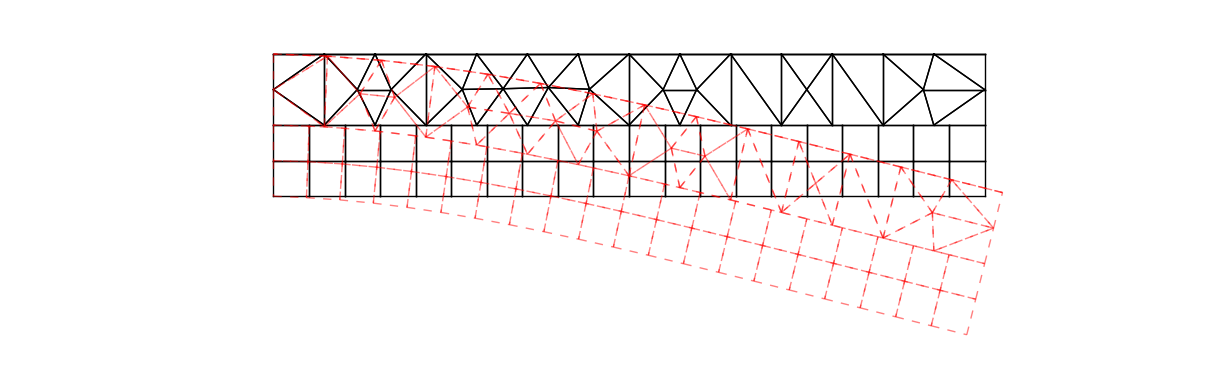

(-20.0,120.0,-20.0,25.0)

In [23]:
fig = figure(figsize=(15, 4))
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    #info(X)
    for i=1:length(X)
        px1 = X[i][1]
        py1 = X[i][2]
        px2 = X[mod(i,length(X))+1][1]
        py2 = X[mod(i,length(X))+1][2]
        plot([px1, px2], [py1, py2], "k-")
    end
end
for element in field_problem.elements
    conn = get_connectivity(element)
    X = element("geometry", 0.0)
    u = element("displacement", 0.0)
    x = X + u
    #info(X)
    for i=1:length(x)
        px1 = x[i][1]
        py1 = x[i][2]
        px2 = x[mod(i,length(x))+1][1]
        py2 = x[mod(i,length(x))+1][2]
        plot([px1, px2], [py1, py2], "r--", alpha=0.5)
    end
end

axis("equal")
axis("off")

## Model 3: splitted beam, frictionless contact, small sliding